Running simulation with MCS=17, Total Tx Power=15, Bandwidth=200 MHz, Central Frequency=41 GHz
Simulation output: Consolidate compiler generated dependencies of target main
[  0%] Building CXX object contrib/nr/examples/CMakeFiles/main.dir/main.cc.o
[  0%] Linking CXX executable ../../../../build/contrib/nr/examples/ns3.41-main-default


Flow 1 (1.0.0.2:49153 -> 7.0.0.2:1234) proto UDP
  Tx Packets: 6000
  Tx Bytes:   14568000
  TxOffered:  194.240000 Mbps
  Rx Bytes:   9415784
  Throughput: 125.543787 Mbps
  Mean delay:  106.562565 ms
  Mean jitter:  0.054503 ms
  Rx Packets: 3878
Flow 2 (1.0.0.2:49154 -> 7.0.0.3:1234) proto UDP
  Tx Packets: 6000
  Tx Bytes:   14568000
  TxOffered:  194.240000 Mbps
  Rx Bytes:   9505620
  Throughput: 126.741600 Mbps
  Mean delay:  104.676965 ms
  Mean jitter:  0.053059 ms
  Rx Packets: 3915
Flow 3 (1.0.0.2:49155 -> 7.0.0.4:1234) proto UDP
  Tx Packets: 6000
  Tx Bytes:   14568000
  TxOffered:  194.240000 Mbps
  Rx Bytes:   9505620
  Throughput: 126

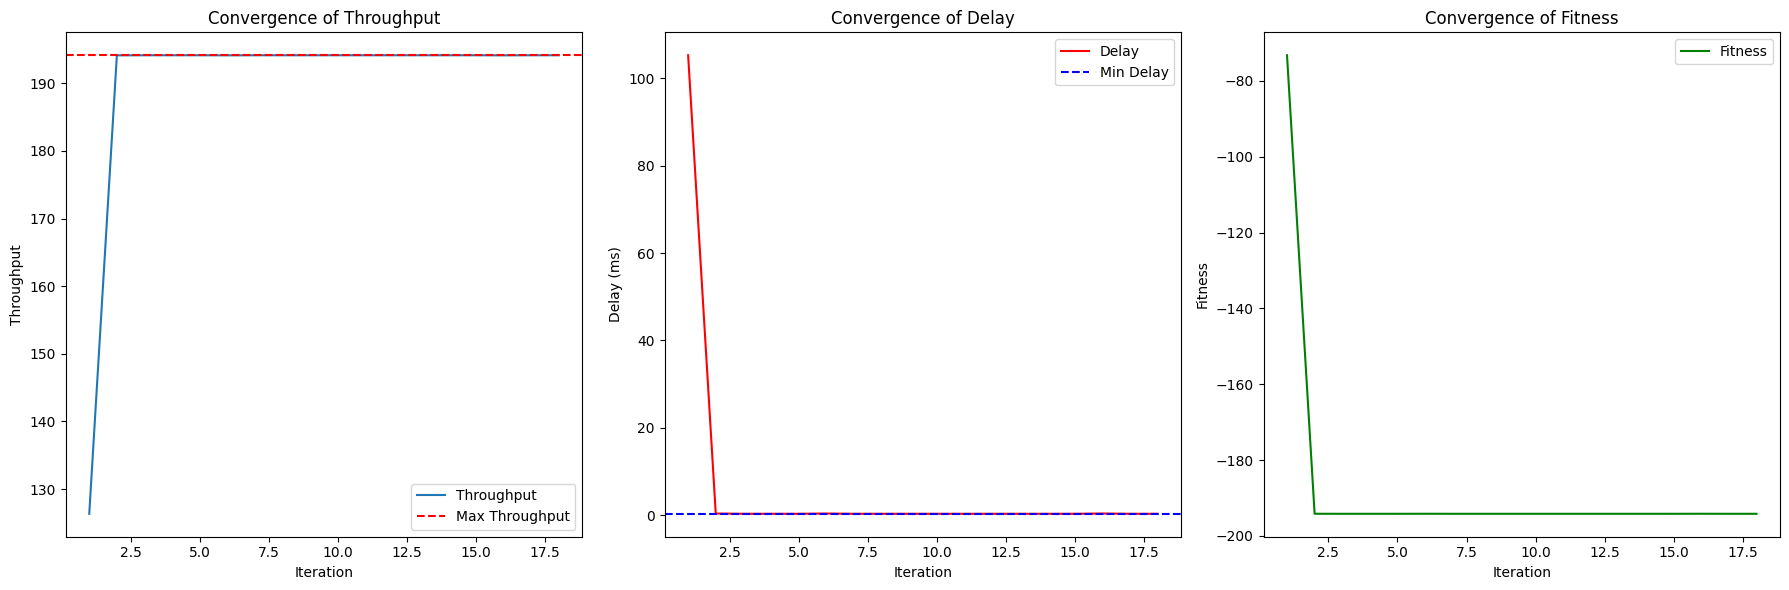

In [20]:
import numpy as np
import subprocess
import random
import matplotlib.pyplot as plt

# Valores pré-definidos para largura de banda e frequência central
bandwidth_values = [100, 200, 400, 800]  # Larguras de banda em MHz
central_frequency_values = [28, 26, 41, 39, 47]  # Frequências em MHz

def run_ns3_simulation(mcs, totalTxPower, bandwidth, centralFrequency):
    ncc = 2  # Valor fixo para NCC
    
    # Executar a simulação com o comando correto
    command = f"./ns3 run main -- --ccNuns={ncc} --mcs={mcs} --bandwidthBand={bandwidth}e6 --totalTxPower={totalTxPower} --centralFrequencyBand={centralFrequency}e9"
    print(f"Running simulation with MCS={mcs}, Total Tx Power={totalTxPower}, Bandwidth={bandwidth} MHz, Central Frequency={centralFrequency} GHz")
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
    if result.returncode != 0:
        print("NS3 Simulation Error:", result.stderr)
        raise Exception("NS3 simulation failed")

    print("Simulation output:", result.stdout)
    output_lines = result.stdout.strip().split("\n")
    mean_throughput = None
    mean_delay = None
    for line in output_lines:
        if "Mean flow throughput:" in line:
            mean_throughput = float(line.split(":")[-1].strip())
        elif "Mean flow delay:" in line:
            mean_delay = float(line.split(":")[-1].strip().split()[0])  # Assume delay está em ms e remove ' ms'

    if mean_throughput is None or mean_delay is None:
        print("Error: Missing throughput or delay metrics in simulation output")
        raise Exception("Missing metrics in simulation output")
    
    print(f"Extracted metrics: Mean Throughput = {mean_throughput}, Mean Delay = {mean_delay}")
    return {'throughput': mean_throughput, 'delay': mean_delay}

def throughput_function(variables_values):
    mcs, totalTxPower, bandwidth_idx, centralFrequency_idx = map(int, variables_values)
    bandwidth = bandwidth_values[bandwidth_idx]
    centralFrequency = central_frequency_values[centralFrequency_idx]
    metrics = run_ns3_simulation(mcs, totalTxPower, bandwidth, centralFrequency)
    
    print(f"Extracted metrics: Throughput = {metrics['throughput']}, Delay = {metrics['delay']}")

    penalty = 0
    if metrics['delay'] > 100:  # Supondo que o limite de delay seja 100 ms
        penalty += (metrics['delay'] - 100) * 10  # Penalidade proporcional ao excesso
        print(f"Penalty applied for delay: {penalty}")

    fitness = metrics['throughput'] - penalty
    print(f"Fitness (negative for minimization): {-fitness}")

    throughput_values.append(metrics['throughput'])
    delay_values.append(metrics['delay'])
    fitness_values.append(-fitness)

    return -fitness  # Negativo porque o PSO minimiza

def apply_constraints(particle, min_values, max_values):
    particle[2] = np.clip(particle[2], 0, len(bandwidth_values) - 1)
    particle[3] = np.clip(particle[3], 0, len(central_frequency_values) - 1)
    return np.clip(particle, min_values, max_values)

def particle_swarm_optimization_with_constraints(target_function, **parameters):
    swarm_size = parameters['swarm_size']
    min_values = np.array(parameters['min_values'])
    max_values = np.array(parameters['max_values'])
    iterations = parameters['iterations']
    decay = parameters['decay']
    w = parameters['w']
    c1 = parameters['c1']
    c2 = parameters['c2']
    verbose = parameters['verbose']

    particles = [np.random.uniform(low=min_values, high=max_values, size=len(min_values)) for _ in range(swarm_size)]
    velocities = [np.random.uniform(low=-1, high=1, size=len(min_values)) for _ in range(swarm_size)]
    personal_best_positions = np.copy(particles)
    personal_best_scores = [target_function(np.round(p).astype(int)) for p in particles]
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = min(personal_best_scores)

    for iteration in range(iterations):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(2)
            velocities[i] = w * velocities[i] + c1 * r1 * (personal_best_positions[i] - particles[i]) + c2 * r2 * (global_best_position - particles[i])
            particles[i] += velocities[i]
            constrained_particles = apply_constraints(particles[i], min_values, max_values)
            score = target_function(np.round(constrained_particles).astype(int))
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = np.copy(constrained_particles)
            if score < global_best_score:
                global_best_score = score
                global_best_position = np.copy(constrained_particles)

        if verbose:
            print(f"Iteration {iteration + 1}, Best Score: {-global_best_score}")

        w *= decay

    return global_best_position, -global_best_score

# Armazenar valores de throughput e delay ao longo das iterações
throughput_values = []
delay_values = []
fitness_values = []

# Parâmetros do PSO
parameters = {
    'swarm_size': 3,
    'min_values': [0, 0.1, 0, 0],  # MCS min, Potência mínima, bandwidth index min, frequency index min
    'max_values': [28, 50, len(bandwidth_values) - 1, len(central_frequency_values) - 1],  # MCS max, Potência máxima, bandwidth index max, frequency index max
    'iterations': 5,
    'decay': 0.95,
    'w': 0.9,
    'c1': 2.0,
    'c2': 2.0,
    'verbose': True
}

# Executar o PSO
pso_result = particle_swarm_optimization_with_constraints(throughput_function, **parameters)

# Imprimir a solução
variables = pso_result[0]
mcs, totalTxPower, bandwidth_idx, centralFrequency_idx = map(int, variables)
bandwidth = bandwidth_values[bandwidth_idx]
centralFrequency = central_frequency_values[centralFrequency_idx]
maximum_throughput = -pso_result[1]  # Convertendo de volta para positivo para mostrar o throughput
print(f'Variables: MCS = {mcs}, Total Tx Power = {totalTxPower}, Bandwidth = {bandwidth} MHz, Central Frequency = {centralFrequency} GHz, Maximum Throughput Found: {round(maximum_throughput, 4)}')

# Plotar gráfico de convergência com destaque para os valores mais relevantes
iterations = list(range(1, len(throughput_values) + 1))

# Encontrar os melhores e piores valores de throughput e delay
max_throughput = max(throughput_values)
min_delay = min(delay_values)
print(f"Maximum Throughput Found: {max_throughput}")
print(f"Minimum Delay Found: {min_delay}")

# Plotar gráficos de convergência
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(iterations, throughput_values, label='Throughput')
plt.axhline(y=max_throughput, color='r', linestyle='--', label='Max Throughput')
plt.xlabel('Iteration')
plt.ylabel('Throughput')
plt.title('Convergence of Throughput')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iterations, delay_values, label='Delay', color='red')
plt.axhline(y=min_delay, color='blue', linestyle='--', label='Min Delay')
plt.xlabel('Iteration')
plt.ylabel('Delay (ms)')
plt.title('Convergence of Delay')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_values, label='Fitness', color='green')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Convergence of Fitness')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
print(f"valores de delay:{delay_values}")
print(f"valores de throughput:{throughput_values}")


valores de delay:[105.31145, 0.353571, 0.294112, 0.294112, 0.294112, 0.353571, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.353571, 0.294112, 0.294112]
valores de throughput:[126.342329, 194.14288, 194.153671, 194.153671, 194.153671, 194.14288, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.14288, 194.153671, 194.153671]


In [22]:
valores_D = [0.353571, 0.294112, 0.294112, 0.294112, 0.353571, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.294112, 0.353571, 0.294112, 0.294112]
valores_T = [194.14288, 194.153671, 194.153671, 194.153671, 194.14288, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.153671, 194.14288, 194.153671, 194.153671]

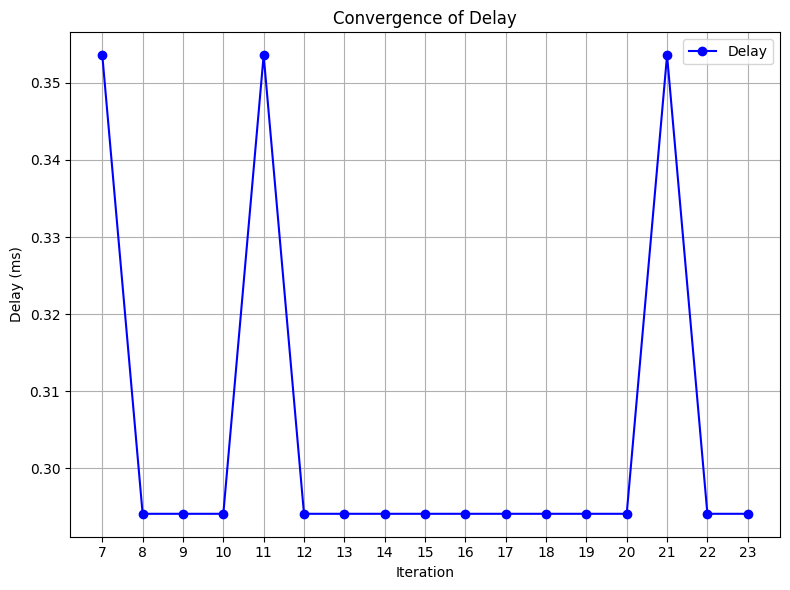

In [30]:
indice_inicial = 7

# Criar o gráfico
plt.figure(figsize=(8, 6))  # Define o tamanho da figura (opcional)

# Plotar os valores
plt.plot(np.arange(len(valores_D)), valores_D, marker='o', linestyle='-', color='b', label='Delay')
# Adicionar título e rótulos aos eixos
plt.title('Convergence of Delay')
plt.xlabel('Iteration')
plt.ylabel('Delay (ms)')

# Definir os marcadores do eixo x começando do índice inicial
plt.xticks(np.arange(len(valores_D)), np.arange(indice_inicial, len(valores_D) + indice_inicial))


# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)  # Adicionar grade (opcional)
plt.tight_layout()  # Ajustar layout (opcional)
plt.show()